In [1]:
import numpy as np
import openl3
import openl3.core
from openl3.models import load_audio_embedding_model

Using TensorFlow backend.
/opt/anaconda3/envs/ol3v1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/ol3v1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/ol3v1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/ol3v1/lib/python3.7/site-pa

In [2]:
import matplotlib.pyplot as plt
import librosa.display

In [3]:
plt.rc('figure', figsize=(16, 4))

In [4]:
from IPython.display import Audio, display as D

In [5]:
import kapre
V2 = kapre.__version__ == '0.3.5'
KAPRE = 'kapre {}'.format(kapre.__version__)
# KAPRE = 'kapre 0.3.5'
KAPRE

'kapre 0.1.4'

In [6]:
def load_audio_frontend(input_repr='linear', content_type="music", embedding_size=6144):
    model = load_audio_embedding_model(input_repr=input_repr, content_type="music", embedding_size=6144)
    specmodel = type(model)(model.inputs, model.layers[1](model.input))
    return specmodel

In [7]:
def diff_plot(input_repr, X_kapre, X_librosa, start=0, n=1, norm=False, shifty=0):
    for xk, xl in zip(X_kapre[start:start+n,...,0], X_librosa[start:start+n,...,0]):
        if norm:
            xl = (xl - xl.max()) / (xl.max() - xl.min())
            xk = (xk - xk.max()) / (xk.max() - xk.min())
        if shifty > 0:
            xl = np.concatenate([xk[:shifty], xl[:-shifty]], axis=0)
        elif shifty < 0:
            xl = np.concatenate([xl[shifty:], xk[-shifty:]], axis=0)
        plt.subplot(141)
        librosa.display.specshow(xk, cmap='magma')
        plt.title(KAPRE)
        plt.colorbar()
        plt.subplot(142)
        librosa.display.specshow(xl, cmap='magma')
        plt.title('librosa')
        plt.colorbar()
        plt.subplot(143)
        librosa.display.specshow(xk - xl[:,:xk.shape[1]], cmap='magma')
        plt.title('kapre - librosa')
        plt.colorbar()
        plt.subplot(144)
        librosa.display.specshow(np.clip(xk - xl[:,:xk.shape[1]], -2, 2), cmap='magma')
        plt.title('kapre - librosa clipped to [-2, 2]')
        plt.colorbar()
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.suptitle('{} - openl3 {}'.format(input_repr, openl3.version.version))
        plt.show()

In [8]:
def compare(input_repr='linear', *a, shifty=0, **kw):
    specmodel = load_audio_frontend(input_repr, *a, **kw)
    X_kapre = specmodel.predict(preprocess(audio, sr, hop_size=1))
    print(KAPRE, 'shape/max/min/range:', X_kapre.shape, X_kapre.max(), X_kapre.min(), X_kapre.max() - X_kapre.min())
    X_librosa = preprocess(audio, sr, hop_size=1, input_repr=input_repr)
    print('librosa shape/max/min/range:', X_librosa.shape, X_librosa.max(), X_librosa.min(), X_librosa.max() - X_librosa.min())
    diff_plot(input_repr, X_kapre, X_librosa, shifty=shifty)

In [9]:
import soundfile as sf

import os
TEST_DIR = '.'#os.path.dirname(__file__)
TEST_AUDIO_DIR = os.path.abspath(os.path.join(TEST_DIR, '../data', 'audio'))
CHIRP_44K_PATH = os.path.join(TEST_AUDIO_DIR, 'chirp_44k.wav')
CHIRP_44K_PATH
# CHIRP_44K_PATH
# audio, sr = sf.read(librosa.example('brahms'))
audio, sr = sf.read(CHIRP_44K_PATH)
audio = audio[:int(sr*10)]
D(Audio(data=audio, rate=sr))
audio.shape, sr, audio.min(), audio.max()

((88200,), 44100, -0.799713134765625, 0.7999267578125)

In [10]:
def _linear_frontend_v1(audio, n_fft=512, hop_length=242, db_amin=1e-10, db_ref=1.0, db_dynamic_range=80.0):
    S = np.abs(librosa.stft(audio, n_fft=n_fft, hop_length=hop_length, center=False))
    S = librosa.power_to_db(S, ref=db_ref, amin=db_amin, top_db=db_dynamic_range)
    S -= S.max()
    return S

def _linear_frontend_v2(audio, n_fft=512, hop_length=242, db_amin=1e-5, db_ref=1.0, db_dynamic_range=80.0):
    S = np.abs(librosa.stft(audio, n_fft=n_fft, hop_length=hop_length, center=False))
    S = librosa.power_to_db(S, ref=db_ref, amin=db_amin, top_db=db_dynamic_range)
    return S


def _mel_frontend_v1(audio, sr=48000, n_mels=128, n_fft=2048, hop_length=242, 
                  db_amin=1e-10, db_ref=1.0, db_dynamic_range=80.0):
#     audio = np.pad(audio, (0, n_fft), 'constant', constant_values=0)
    S = librosa.feature.melspectrogram(audio, sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length, center=True, power=1.0)
    S = librosa.power_to_db(S, ref=db_ref, amin=db_amin, top_db=db_dynamic_range)
    S -= S.max()
    return S

def _mel_frontend_v2(audio, sr=48000, n_mels=128, n_fft=2048, hop_length=242, 
                  db_amin=1e-5, db_ref=1.0, db_dynamic_range=80.0):
    audio = np.pad(audio, (0, n_fft), 'constant', constant_values=0)
    S = librosa.feature.melspectrogram(audio, sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length, center=False, power=1.0)
    S = librosa.power_to_db(S, ref=db_ref, amin=db_amin, top_db=db_dynamic_range)
    return S

_linear_frontend, _mel_frontend = (
    (_linear_frontend_v2, _mel_frontend_v2) if kapre.__version__ == '0.3.5' else (_linear_frontend_v1, _mel_frontend_v1))


def preprocess(audio, sr, hop_size=0.1, center=True, input_repr=None, **kw):
    x = openl3.core._preprocess_audio_batch(audio, sr, hop_size=hop_size, center=center)
    if input_repr:
        if input_repr == 'linear':
            x = np.stack([_linear_frontend(xi[0], **kw) for xi in x])[...,None]
        elif input_repr == 'mel128':
            x = np.stack([_mel_frontend(xi[0], n_mels=128, **kw) for xi in x])[...,None]
        elif input_repr == 'mel256':
            x = np.stack([_mel_frontend(xi[0], n_mels=256, **kw) for xi in x])[...,None]
    return x

Instructions for updating:
Colocations handled automatically by placer.
kapre 0.1.4 shape/max/min/range: (3, 128, 199, 1) 0.0 -80.0 80.0
librosa shape/max/min/range: (3, 128, 199, 1) 0.0 -80.0 80.0


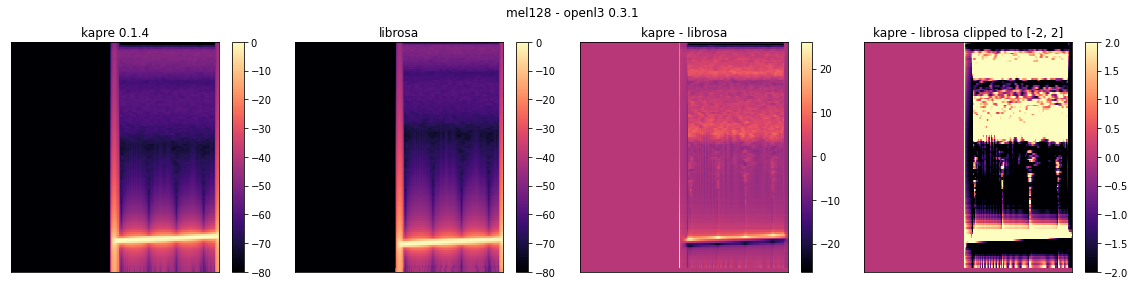

In [11]:
compare('mel128', shifty=2)

kapre 0.1.4 shape/max/min/range: (3, 257, 197, 1) 0.0 -80.0 80.0
librosa shape/max/min/range: (3, 257, 197, 1) 0.0 -80.0 80.0


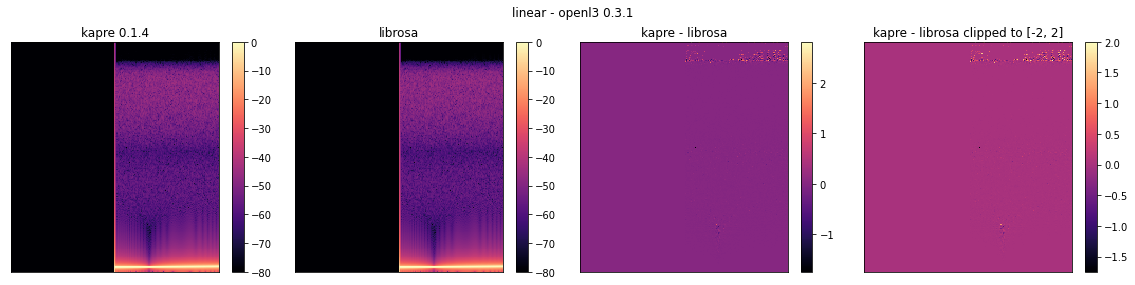

kapre 0.1.4 shape/max/min/range: (3, 128, 199, 1) 0.0 -80.0 80.0
librosa shape/max/min/range: (3, 128, 199, 1) 0.0 -80.0 80.0


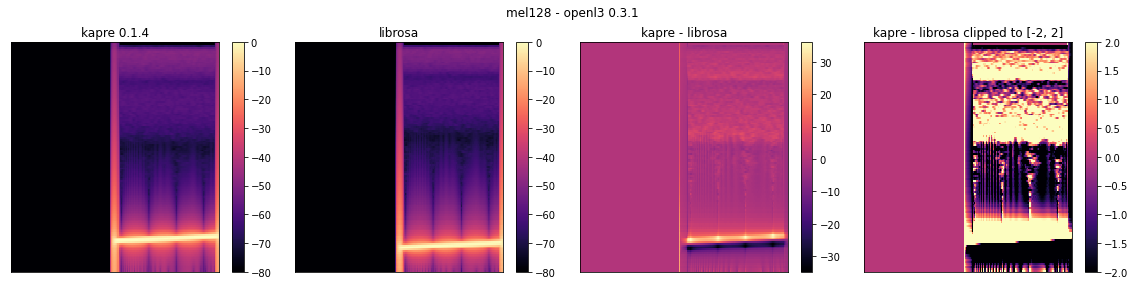

kapre 0.1.4 shape/max/min/range: (3, 256, 199, 1) 0.0 -80.0 80.0
librosa shape/max/min/range: (3, 256, 199, 1) 0.0 -80.0 80.0


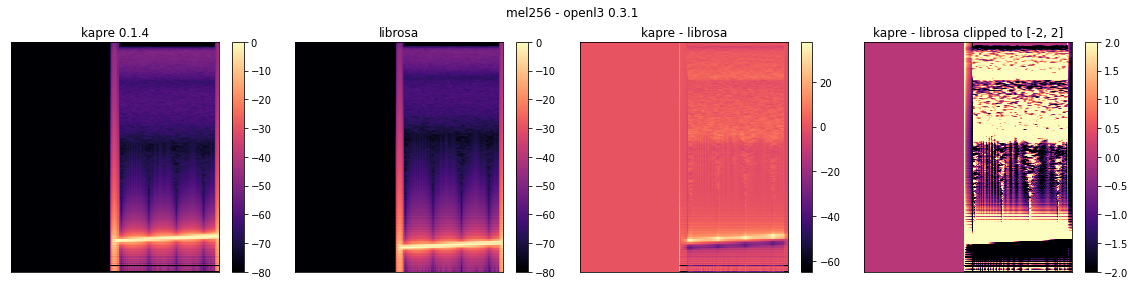

In [12]:
for input_repr in ['linear', 'mel128', 'mel256']:
    compare(input_repr)

In [13]:
# def power_to_db(S, ref=1.0, amin=1e-10, top_db=80.0):
#     S = np.asarray(S)
#     ref = ref(S) if callable(ref) else np.abs(ref)

#     log_spec = 10.0 * np.log10(np.maximum(amin, S))
#     log_spec -= 10.0 * np.log10(np.maximum(amin, ref))
#     print(log_spec.max(), log_spec.min(), top_db, log_spec.max() - top_db)
#     if top_db is not None:
#         log_spec = np.maximum(log_spec, log_spec.max() - top_db)
#     return log_spec

# def amplitude_to_db(S, ref=1.0, amin=1e-5, top_db=80.0):
#     S = np.abs(np.asarray(S))
#     ref = ref(S) if callable(ref) else np.abs(ref)
#     power = np.square(S, out=S)
#     return power_to_db(power, ref=ref**2, amin=amin**2, top_db=top_db)

In [14]:
input_repr = 'mel128'
specmodel = load_audio_frontend(input_repr)
specmodel.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 1, 48000)          0         
_________________________________________________________________
melspectrogram_4 (Melspectro (None, 128, 199, 1)       4329600   
Total params: 4,329,600
Trainable params: 0
Non-trainable params: 4,329,600
_________________________________________________________________


```python
def _log10(x):
    return tf.math.log(x) / tf.math.log(tf.constant(10, dtype=x.dtype))

# This is essentially what old kapre uses

def magnitude_to_decibel_v1(x, amin=1e-10, dynamic_range=80.0):
    max_axis = tuple(range(K.ndim(x))[1:]) or None
    amin = tf.cast(amin or 1e-10, dtype=x.dtype)
    log_spec = 10. * _log10(K.maximum(x, amin))
    log_spec = K.maximum(
        log_spec - K.max(log_spec, axis=max_axis, keepdims=True), 
        -dynamic_range)
    return log_spec

# This is essentially what new kapre uses

def magnitude_to_decibel_v2(x, ref_value=1.0, amin=1e-5, dynamic_range=80.0):
    max_axis = tuple(range(K.ndim(x))[1:]) or None
    amin = tf.cast(amin if amin is None else 1e-5, dtype=x.dtype)
    log_spec = 10.0 * _log10(tf.math.maximum(x, amin))
    log_spec -= 10.0 * _log10(tf.math.maximum(amin, ref_value))
    log_spec = tf.math.maximum(
        log_spec, 
        K.max(log_spec, axis=max_axis, keepdims=True) - dynamic_range)
    return log_spec
```

In [15]:
X_kapre = specmodel.predict(preprocess(audio, sr, hop_size=1))
X_kapre.shape

(3, 128, 199, 1)

In [16]:
X_librosa = preprocess(audio, sr, hop_size=1, input_repr=input_repr)
X_librosa.shape

(3, 128, 199, 1)

kapre 0.1.4 max/min/range: 0.0 -80.0 80.0
librosa max/min/range: 0.0 -80.0 80.0


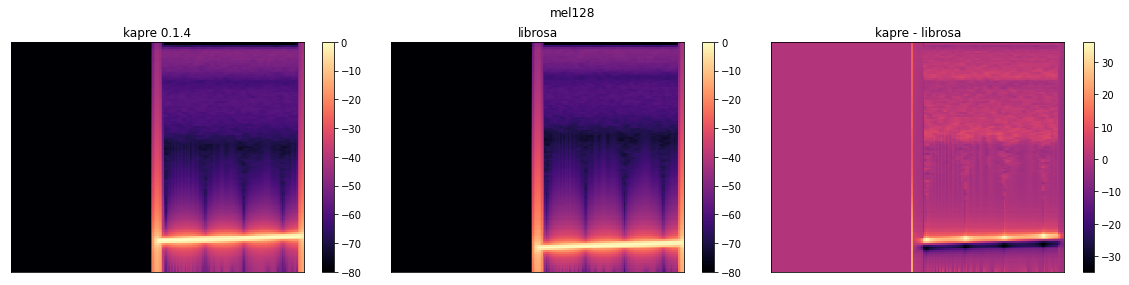

kapre 0.1.4 max/min/range: 0.0 -80.0 80.0
librosa max/min/range: 0.0 -80.0 80.0


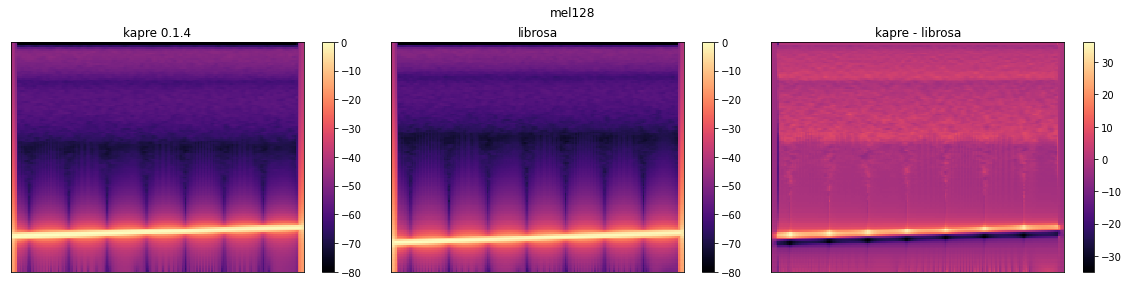

kapre 0.1.4 max/min/range: 0.0 -80.0 80.0
librosa max/min/range: 0.0 -80.0 80.0


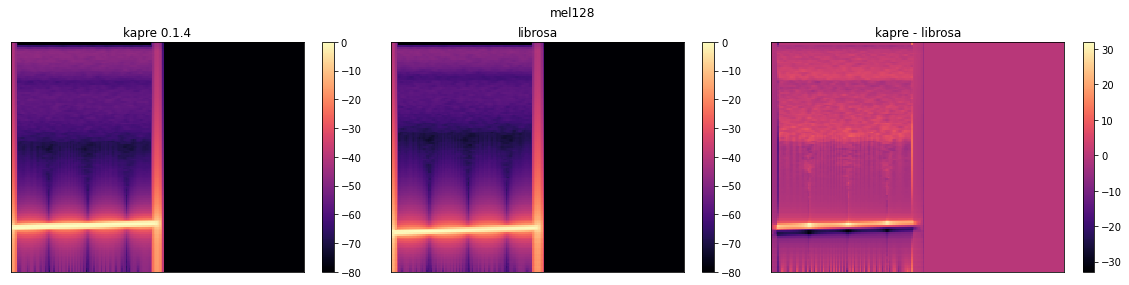

In [17]:
for xk, xl in zip(X_kapre[...,0], X_librosa[...,0]):
    print(KAPRE, 'max/min/range:', xk.max(), xk.min(), xk.max() - xk.min())
    print('librosa max/min/range:', xl.max(), xl.min(), xl.max() - xl.min())
#     xl = (xl - xl.max()) / (xl.max() - xl.min())
#     xk = (xk - xk.max()) / (xk.max() - xk.min())
    plt.subplot(131)
    librosa.display.specshow(xk, cmap='magma')
    plt.title(KAPRE)
    plt.colorbar()
    plt.subplot(132)
    librosa.display.specshow(xl, cmap='magma')
    plt.title('librosa')
    plt.colorbar()
    plt.subplot(133)
    librosa.display.specshow(xk - xl[:,:xk.shape[1]], cmap='magma')
    plt.title('kapre - librosa')
    plt.colorbar()
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle(input_repr)
    plt.show()